In [1]:
!pip install biopython

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.1.2 -> 25.2
[notice] To update, run: python -m pip install --upgrade pip


In [2]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import re
from Bio import SeqIO
from collections import Counter
from tqdm import tqdm
from math import comb

Create DataFrame with data about inverted repeats (IRs) found by Palindrome Analyzer (size 6-30, spacer 0-10, mismatches 0-1)

In [4]:
irs = pd.read_csv('input/irs_with_mms.txt', sep='\t')
irs.rename(columns={'energy': 'Energy', 'pos': 'Position'}, inplace=True)
irs[['Length', 'Spacer_length', 'Mismatch_count']] = irs['tosplit'].str.split('-', expand=True)
irs[['Sequence', 'Spacer', 'Opposite']] = irs['seqs'].str.split(' ', expand=True)
irs = irs.astype({
                'Length': int,
                'Spacer_length': int,
                'Mismatch_count': int,
                'Position': int,
                'Energy': float})
irs.drop(columns=['seqs', 'tosplit'], inplace=True)
mask = irs['Opposite'].isna()
irs.loc[mask, ['Opposite', 'Spacer']] = irs.loc[mask, ['Spacer', 'Opposite']].values
irs.fillna('', inplace=True)

Define a Python class for IRs.

In [5]:
class IR:

    def __init__(self, Position, Length, Spacer_length, Mismatch_count, Energy, Sequence, Spacer, Opposite):
        self.Position = Position
        self.Length = Length
        self.Spacer_length = Spacer_length
        self.Mismatch_count = Mismatch_count
        self.Energy = Energy
        self.End = Position + 2*Length + Spacer_length
        self.Sequence = Sequence
        self.Spacer = Spacer
        self.Opposite = Opposite

    def __repr__(self):
        return f'IR at position {self.Position}: {self.Sequence}_{self.Spacer}_{self.Opposite}. Energy = {self.Energy}'

    def __len__(self):
        return 2*self.Length + self.Spacer_length

    def is_intersecting(self, other):
        return (self.Position <= other.Position < self.End) or (other.Position <= self.Position < other.End)

Combine IRs into components as if each IR represented a node in a graph, where 2 IRs are adjacent iff their DNA regions intersect.

In [6]:
components = [set()]
for row in irs.itertuples():
    ir1 = IR(row.Position, row.Length, row.Spacer_length, row.Mismatch_count, row.Energy, row.Sequence, row.Spacer, row.Opposite)
    if not any(ir1.is_intersecting(ir2) for ir2 in components[-1]):
        components.append({ir1})
    else:
        components[-1].add(ir1)
components.pop(0)

set()

Now we construct several types of covers, that is, we select IRs from each component by some criteria.
Let's begin with choosing the most stable IR from each component (the most stable = the lowest energy).

In [7]:
min_energy_cover = []
for component in components:
    min_energy_cover.append(min(component, key=lambda x: (x.Energy, -len(x), x.Position)))

Now the shortest IR from component.

In [8]:
min_len_cover = []
for component in components:
    min_len_cover.append(min(component, key=lambda x: (len(x), x.Energy, x.Position)))

Now we apply a dinamic algorithm to select IRs with maximal total length/spacer length from each component.

In [9]:
def optimal_len(component):
    c = sorted(list(component), key=lambda x: x.End) #sort IRs by their End
    non_inter = [] #for each IR, remember the biggest index j, so that for any k <= j c[k] does not intersect our IR
    for i in range(len(c)):
        for j in range(len(c)):
            if c[j].is_intersecting(c[i]):
                non_inter.append(j - 1)
                break
    dp = {-1: []}
    for i in range(len(c)):
        dp[i] = max(dp[i - 1], dp[non_inter[i]] + [c[i]], key=lambda x: sum([len(y) for y in x]))
    return dp[len(c) - 1]

optimal_len_cover = []
for component in components:
    optimal_len_cover += optimal_len(component)

def optimal_spacer_len(component):
    c = sorted(list(component), key=lambda x: x.End) #sort IRs by their End
    non_inter = [] #for each IR, remember the biggest index j, so that for any k <= j c[k] does not intersect our IR
    for i in range(len(c)):
        for j in range(len(c)):
            if c[j].is_intersecting(c[i]):
                non_inter.append(j - 1)
                break
    dp = {-1: []}
    for i in range(len(c)):
        dp[i] = max(dp[i - 1], dp[non_inter[i]] + [c[i]], key=lambda x: sum([y.Spacer_length for y in x]))
    return dp[len(c) - 1]

optimal_spacer_len_cover = []
for component in components:
    optimal_spacer_len_cover += optimal_spacer_len(component)

Now we apply a greedy algorithm to choose the most stable hairpin at every iteration.

In [10]:
def greedy_energy(component):
    selected = []
    ir_left = component.copy() #all IRs we can choose from, i.e. all not intersecting those already selected
    while ir_left:
        selected.append(min(ir_left, key=lambda x: (x.Energy, -len(x), x.Position)))
        ir_left = {ir for ir in ir_left if not ir.is_intersecting(selected[-1])}
    return selected

greedy_energy_cover = []
for component in components:
    greedy_energy_cover += greedy_energy(component)

Finally, we select all IRs.

In [11]:
all_irs = [IR(row.Position, row.Length, row.Spacer_length, row.Mismatch_count, row.Energy, row.Sequence, row.Spacer, row.Opposite) for row in irs.itertuples()]

In [ ]:
#cover = min_energy_cover
#cover = greedy_energy_cover
#cover = optimal_len_cover
#cover = min_len_cover
cover = optimal_spacer_len_cover
#cover = all_irs

Create an array for the genome and mark all positions covered by IRs as 1.

In [143]:
file = open('input/mpox_genome_seq.fna')
mpox_genome = list(SeqIO.parse(file, 'fasta'))[0]
genome_length = len(mpox_genome.seq)
genome = [0 for i in range(genome_length + 1)]
for ir in cover:
    genome[ir.Position: ir.End] = [1 for i in range(len(ir))]
genome = genome[1:]

And the same, but we mark only spacer regions.

In [144]:
genome_spacers = [0 for i in range(genome_length + 1)]
for ir in cover:
    genome_spacers[ir.Position + ir.Length: ir.Position + ir.Length + ir.Spacer_length] = [1 for i in range(ir.Spacer_length)]
genome_spacers = genome_spacers[1:]

Read the file with information about mutations occured in newer MPOX strains.

In [145]:
snp_locations = pd.read_excel('input/snp_locations.xlsx')
num_of_snps = len(snp_locations[snp_locations['isAPOBEC'] == 1])

Let's have a look at how often real mutations (only in APOBEC sites) occur in IRs (depending on our cover).

In [146]:
print(f'Percentage of genomic sequence covered by selected IRs: {round(sum(genome)/len(genome)*100, 2)}%')
print(f'Percentage of genomic sequence covered by selected spacers: {round(sum(genome_spacers)/len(genome)*100, 2)}%')
print(f'Expected number of mutations in IRs: {round(sum(genome)/len(genome)*num_of_snps)}.')
print(f'Expected number of mutations in spacers: {round(sum(genome_spacers)/len(genome)*num_of_snps)}.')
in_irs = sum(snp_locations[snp_locations['isAPOBEC'] == 1]['Position'].apply(lambda x: genome[x - 1]))
in_spacers = sum(snp_locations[snp_locations['isAPOBEC'] == 1]['Position'].apply(lambda x: genome_spacers[x - 1]))
print(f'Actual number of mutations in IRs: {in_irs}.')
print(f'Actual number of mutations in spacers: {in_spacers}.')

Percentage of genomic sequence covered by selected IRs: 44.49%
Percentage of genomic sequence covered by selected spacers: 12.46%
Expected number of mutations in IRs: 25.
Expected number of mutations in spacers: 7.
Actual number of mutations in IRs: 26.
Actual number of mutations in spacers: 8.


Simulate random mutations in APOBEC-mutagenesis sites (TC and GA in the opposite strand) and count, how many of them occured inside our cover.

In [147]:
mut_sites = [m.start() + 1 for m in re.finditer(r'((?<=T)C)|(G(?=A))', str(mpox_genome.seq))]
mut_sites_in_cover = len([m for m in mut_sites if genome[m - 1]])
mut_sites_in_spacers = len([m for m in mut_sites if genome_spacers[m - 1]])
distr = []
distr_spacers = []
n_sims = 100000
for i in range(n_sims):
    snp_locs = random.sample(mut_sites, num_of_snps)
    how_many_in_irs = sum([genome[x - 1] == 1 for x in snp_locs])
    how_many_in_spacers = sum([genome_spacers[x - 1] == 1 for x in snp_locs])
    distr.append(how_many_in_irs)
    distr_spacers.append(how_many_in_spacers)

Now instead of simulation we design binomial distribution.

In [148]:
def bernulli(p, n, k):
    return comb(n, k) * p**k * (1 - p)**(n - k)

Calculate p-value for the hypothesis "Actual APOBEC mutations prefer IR regions" compared to our simulations.

In [149]:
p = sum([x >= in_irs for x in distr])/len(distr)
p_spacers = sum([x >= in_spacers for x in distr_spacers])/len(distr_spacers)
print(f'p-value for whole IRs: {round(p*100, 3)}%')
print(f'p-value for spacers: {round(p_spacers*100, 3)}%')

p-value for whole IRs: 23.391%
p-value for spacers: 47.392%


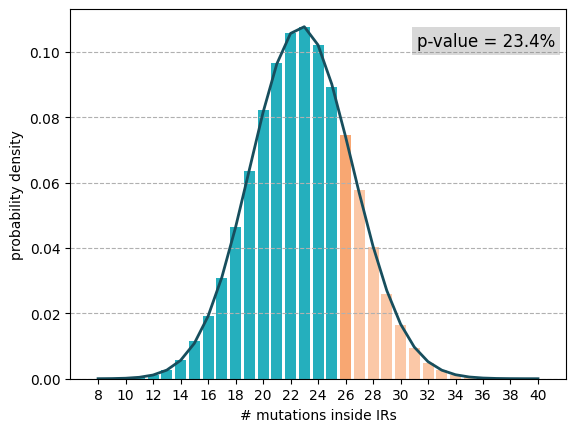

In [150]:
bars = Counter(distr)
for k in bars.keys():
    bars[k] = bars[k] / n_sims
bernulli_pins = {}
for k in range(min(bars.keys()), max(bars.keys()) + 1):
    bernulli_pins[k] = bernulli(mut_sites_in_cover / len(mut_sites), num_of_snps, k)
c = []
for i in bars.keys():
    if i < in_irs:
        c.append('#25afbd')
    if i == in_irs:
        c.append('#f8a772')
    if i > in_irs:
        c.append('#fbc8a7')
plt.bar(bars.keys(), bars.values(), color=c)
plt.xticks(np.arange(min(bars.keys()), max(bars.keys()) + 1, 2))
plt.grid(True, ls= '--', axis='y')
plt.plot(bernulli_pins.keys(), bernulli_pins.values(), color='#174e5d', lw=2)
plt.xlabel('# mutations inside IRs')
plt.ylabel('probability density')
plt.text(0.7, 0.9, f'p-value = {round(p*100, 1)}%', transform=plt.gca().transAxes, fontsize=12, bbox=dict(ls='', boxstyle='square', facecolor='grey', alpha=0.3))
# plt.savefig("optimal_len_irs.png", dpi=300, bbox_inches='tight')
plt.show()

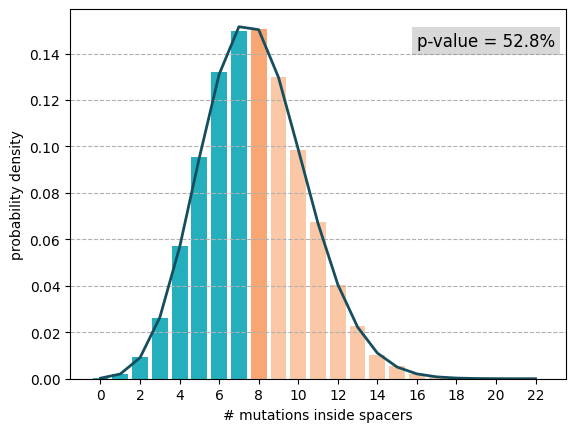

In [137]:
bars = Counter(distr_spacers)
for k in bars.keys():
    bars[k] = bars[k] / n_sims
bernulli_spacers = {}
for k in range(min(bars.keys()), max(bars.keys()) + 1):
    bernulli_spacers[k] = bernulli(mut_sites_in_spacers / len(mut_sites), num_of_snps, k)
c = []
for i in bars.keys():
    if i < in_spacers:
        c.append('#25afbd')
    if i == in_spacers:
        c.append('#f8a772')
    if i > in_spacers:
        c.append('#fbc8a7')
plt.bar(bars.keys(), bars.values(), color=c)
plt.xticks(np.arange(min(bars.keys()), max(bars.keys()) + 1, 2))
plt.grid(True, ls= '--', axis='y')
plt.plot(bernulli_spacers.keys(), bernulli_spacers.values(), color='#174e5d', lw=2)
plt.xlabel('# mutations inside spacers')
plt.ylabel('probability density')
plt.text(0.7, 0.9, f'p-value = {round(p_spacers*100, 1)}%', transform=plt.gca().transAxes, fontsize=12, bbox=dict(ls='', boxstyle='square', facecolor='grey', alpha=0.3))
# plt.savefig("opt_len_spacers.png", dpi=300, bbox_inches='tight')
plt.show()

Now let's check the hypothesis "APOBEC prefers TC or simply C at 3'-ends of hairpin loops (and GA/A at 5' for the opposite strand)".

In [138]:
#construct dataframe with IRs in our cover
irs_cover = pd.DataFrame({'Position': [ir.Position for ir in cover],
             'Energy': [ir.Energy for ir in cover],
             'Length': [ir.Length for ir in cover],
             'Spacer_length': [ir.Spacer_length for ir in cover],
             'Mismatch_count': [ir.Mismatch_count for ir in cover],
             'Sequence': [ir.Sequence for ir in cover],
             'Spacer': [ir.Spacer for ir in cover],
             'Opposite': [ir.Opposite for ir in cover]})
#remember 5'-TC/C positions in selected IRs
loop_tc_locs = []
for row in irs_cover[irs_cover['Spacer'].str.endswith('TC')].itertuples():
    ir = IR(row.Position, row.Length, row.Spacer_length, row.Mismatch_count, row.Energy, row.Sequence, row.Spacer, row.Opposite)
    loop_tc_locs.append(ir.Position + ir.Length + ir.Spacer_length - 1)
for row in irs_cover[irs_cover['Spacer'].str.startswith('GA')].itertuples():
    ir = IR(row.Position, row.Length, row.Spacer_length, row.Mismatch_count, row.Energy, row.Sequence, row.Spacer, row.Opposite)
    loop_tc_locs.append(ir.Position + ir.Length)
loop_tc_locs = list(set(loop_tc_locs))
loop_c_locs = []
for row in irs_cover[irs_cover['Spacer'].str.endswith('C')].itertuples():
    ir = IR(row.Position, row.Length, row.Spacer_length, row.Mismatch_count, row.Energy, row.Sequence, row.Spacer, row.Opposite)
    loop_c_locs.append(ir.Position + ir.Length + ir.Spacer_length - 1)
for row in irs_cover[irs_cover['Spacer'].str.startswith('G')].itertuples():
    ir = IR(row.Position, row.Length, row.Spacer_length, row.Mismatch_count, row.Energy, row.Sequence, row.Spacer, row.Opposite)
    loop_c_locs.append(ir.Position + ir.Length)
loop_c_locs = list(set(loop_c_locs))
#simulate mutations in APOBEC sites
tc_distr = []
c_distr = []
for i in range(n_sims):
    rand = set(random.sample(mut_sites, num_of_snps))
    tc_distr.append(len(set(loop_tc_locs).intersection(rand)))
    c_distr.append(len(set(loop_c_locs).intersection(rand)))
#count real mutations in such positions
in_loop_tc = sum(snp_locations['Position'].apply(lambda x: x in loop_tc_locs))
print(f"{in_loop_tc} mutations are in TC at 3' end of loops.")
in_loop_c = sum(snp_locations['Position'].apply(lambda x: x in loop_c_locs))
print(f"{in_loop_c} mutations are in C at 3' end of loops.")
#calculate p-value
p_tc = round((sum([x >= in_loop_tc for x in tc_distr])/len(tc_distr)*100), 3)
p_c = round((sum([x >= in_loop_c for x in c_distr])/len(c_distr)*100), 3)
print(f'p-value for TC is {p_tc}%')
print(f'p-value for C is {p_c}%')

3 mutations are in TC at 3' end of loops.
3 mutations are in C at 3' end of loops.
p-value for TC is 13.163%
p-value for C is 15.356%


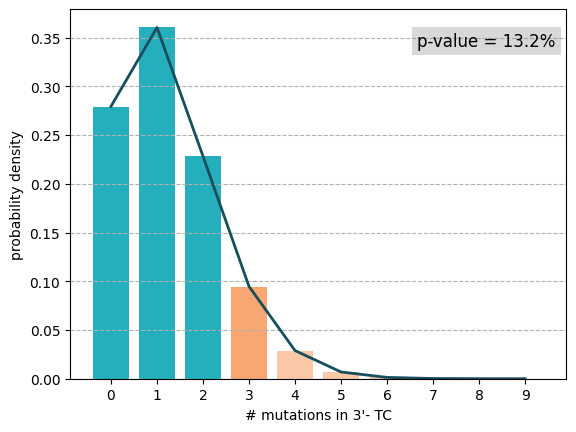

In [139]:
bars = Counter(tc_distr)
for k in bars.keys():
    bars[k] = bars[k] / n_sims
bernulli_tc = {}
for k in range(min(bars.keys()), max(bars.keys()) + 1):
    bernulli_tc[k] = bernulli(len(loop_tc_locs) / len(mut_sites), num_of_snps, k)
c = []
for i in bars.keys():
    if i < in_loop_tc:
        c.append('#25afbd')
    if i == in_loop_tc:
        c.append('#f8a772')
    if i > in_loop_tc:
        c.append('#fbc8a7')
plt.bar(bars.keys(), bars.values(), color=c)
plt.xticks(np.arange(min(bars.keys()), max(bars.keys()) + 1, 1))
plt.grid(True, ls= '--', axis='y')
plt.plot(bernulli_tc.keys(), bernulli_tc.values(), color='#174e5d', lw=2)
plt.xlabel("# mutations in 3'- TC")
plt.ylabel('probability density')
plt.text(0.7, 0.9, f'p-value = {round(p_tc, 1)}%', transform=plt.gca().transAxes, fontsize=12, bbox=dict(ls='', boxstyle='square', facecolor='grey', alpha=0.3))
# plt.savefig("opt_len_tc.png", dpi=300, bbox_inches='tight')
plt.show()

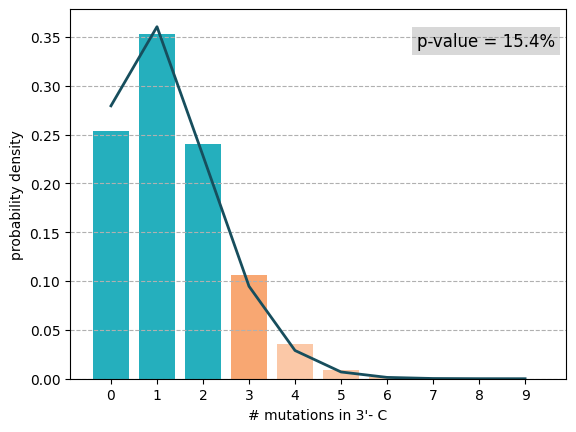

In [140]:
bars = Counter(c_distr)
for k in bars.keys():
    bars[k] = bars[k] / n_sims
bernulli_c = {}
for k in range(min(bars.keys()), max(bars.keys()) + 1):
    bernulli_c[k] = bernulli(len(loop_tc_locs) / len(mut_sites), num_of_snps, k)
c = []
for i in bars.keys():
    if i < in_loop_c:
        c.append('#25afbd')
    if i == in_loop_c:
        c.append('#f8a772')
    if i > in_loop_c:
        c.append('#fbc8a7')
plt.bar(bars.keys(), bars.values(), color=c)
plt.xticks(np.arange(min(bars.keys()), max(bars.keys()) + 1, 1))
plt.grid(True, ls= '--', axis='y')
plt.plot(bernulli_c.keys(), bernulli_c.values(), color='#174e5d', lw=2)
plt.xlabel("# mutations in 3'- C")
plt.ylabel('probability density')
plt.text(0.7, 0.9, f'p-value = {round(p_c, 1)}%', transform=plt.gca().transAxes, fontsize=12, bbox=dict(ls='', boxstyle='square', facecolor='grey', alpha=0.3))
# plt.savefig("opt_len_c.png", dpi=300, bbox_inches='tight')
plt.show()